# Import modules

Firstly, let's import the modules that we will work with

In [24]:
import xarray as xr # For creating a NetCDF file
from datetime import datetime as dt # Handline dates and times
import uuid # Creating a universally unique identifier (UUID) for your file
import pandas as pd # Importing tabular data from a file (e.g. XLSX, CSV)
import numpy as np # Working with arrays of data and mathematical functions

# Importing your data

The first thing is to load your data into python. I don't have any data, so I will create dummy data for myself to work with.

### From CSV/Excel to a dataframe

In [8]:
# df = pd.read_csv('/path/to/your/file.csv') # CSV files
# df = pd.read_excel('/path/to/your/file.xlsx', sheet_name='Sheet1') # Excel file

### Arrays of data

# Initialising your xarray dataset object

The first step is to create an empty xarray dataset object. 

In [12]:
xrds = xr.Dataset()
print(xrds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


Right away we can see the object has a defined structure with dimensions and variables. A key feature of a NetCDF file is that there is a defined strucutre so your data and metadata will always be in the same place within the file. This makes it easier for a machine to read it. We will add more types of data and metadata to this object as we go.

# Dimensions and coordinate variables

Dimensions define the shape of your data. Variables (your data) can be assigned one or more dimensions. A dimension in most cases is a spatial or temporal dimension (e.g. time, depth, latitude, longitude) but could also be something else (e.g. iteration, number of vertices for data representative of cells).

Dimensions tell you how many points you have for each coordinate. Coordinate variables tell you what the values for those points are.

Let's imagine a few simple scenarios. I'll initialise new xarray dataset objects each time.

### Our data is a time series with 10 points in time.

In [18]:
time = [0,1,2,3,4,5,6,7,8,9]

xrds = xr.Dataset(
    coords = {
        'time': time
    }
)

print(xrds)

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    *empty*


The object has a dimension of length 10 and a coordinate variable (time) which has a dimension of time. The values are all integers. Some more examples. 

### Your times are timestamps

In [27]:
# Creating an array of timestamps
start = np.datetime64('2022-01-01T00:00:00')
end = start + np.timedelta64(24, 'h')
timestamps = np.arange(start, end, np.timedelta64(1, 'h'))

print(timestamps)

['2022-01-01T00:00:00' '2022-01-01T01:00:00' '2022-01-01T02:00:00'
 '2022-01-01T03:00:00' '2022-01-01T04:00:00' '2022-01-01T05:00:00'
 '2022-01-01T06:00:00' '2022-01-01T07:00:00' '2022-01-01T08:00:00'
 '2022-01-01T09:00:00' '2022-01-01T10:00:00' '2022-01-01T11:00:00'
 '2022-01-01T12:00:00' '2022-01-01T13:00:00' '2022-01-01T14:00:00'
 '2022-01-01T15:00:00' '2022-01-01T16:00:00' '2022-01-01T17:00:00'
 '2022-01-01T18:00:00' '2022-01-01T19:00:00' '2022-01-01T20:00:00'
 '2022-01-01T21:00:00' '2022-01-01T22:00:00' '2022-01-01T23:00:00']


In [28]:
# In CF-NetCDF, time is stored in e.g. seconds since 2022-01-01T00:00:00Z, hours since 2022-01-01T00:00:00Z
seconds_since_start = (timestamps - start).astype('int')
hours_since_start = (timestamps - start).astype('timedelta64[h]').astype('int')

print(seconds_since_start)
print(hours_since_start)

[    0  3600  7200 10800 14400 18000 21600 25200 28800 32400 36000 39600
 43200 46800 50400 54000 57600 61200 64800 68400 72000 75600 79200 82800]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [29]:
# Add them to an xarray object

xrds = xr.Dataset(
    coords = {
        'time': seconds_since_start
        }
    )

print(xrds)

<xarray.Dataset>
Dimensions:  (time: 24)
Coordinates:
  * time     (time) int64 0 3600 7200 10800 14400 ... 72000 75600 79200 82800
Data variables:
    *empty*


### We have multiple dimensions

In [22]:
depth = [0,10,20,50,100]
latitude = [78.5425, 79.1423, 80.7139]
longitude = [30.0131,28.7269]

xrds = xr.Dataset(
    coords = {
        'depth': depth,
        'latitude': latitude,
        'longitude': longitude
    }
)

print(xrds)

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * depth      (depth) int64 0 10 20 50 100
  * latitude   (latitude) float64 78.54 79.14 80.71
  * longitude  (longitude) float64 30.01 28.73
Data variables:
    *empty*


# Data Variables

Now let's add some data variables. Starting from the xarray dataset object created directly above that has multiple dimensions.

You can choose what name you assign for each variable. This is not standardised, but be sensible and clear. I will show you how to make your data variables conform to the CF conventions using variable attributes in the next section

### 1D array, e.g. a depth profile

<xarray.Dataset>
Dimensions:        (time: 24, depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * time           (time) int64 0 3600 7200 10800 ... 72000 75600 79200 82800
Dimensions without coordinates: depth, latitude, longitude
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 2 5 2 4 7 3


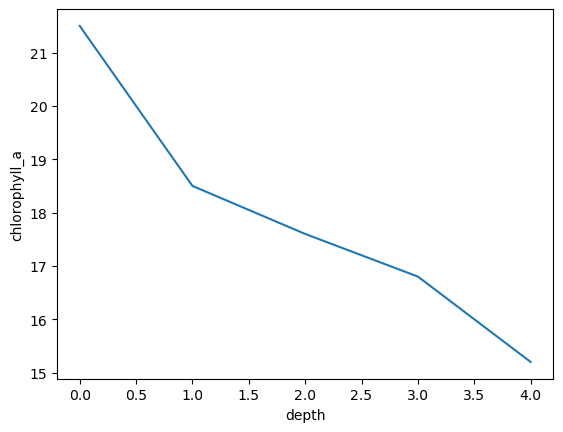

In [47]:
chlorophyll_a = [21.5, 18.5, 17.6, 16.8, 15.2] # Must be same length as the depth dimension

xrds['chlorophyll_a'] = ("depth", chlorophyll_a)

print(xrds)
xrds['chlorophyll_a'].plot()

### 2D array, e.g. a grid of latitude and longitudes

In [41]:
wind_speed = np.random.randint(0, 10, size=(3, 2))    # Creating a 2D array
print(wind_speed)

[[2 5]
 [2 4]
 [7 3]]


In [43]:
xrds['wind_speed'] = (["latitude", "longitude"], wind_speed)
print(xrds)

<xarray.Dataset>
Dimensions:        (time: 24, depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * time           (time) int64 0 3600 7200 10800 ... 72000 75600 79200 82800
Dimensions without coordinates: depth, latitude, longitude
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 2 5 2 4 7 3


Now you can see that the wind_speed variable has two dimensions; latitude and longitude. It appears as a 1D array above, but it we retrieve it we see that it isn't.

In [45]:
xrds['wind_speed']

<xarray.DataArray 'wind_speed' (latitude: 3, longitude: 2)>
array([[2, 5],
       [2, 4],
       [7, 3]])
Dimensions without coordinates: latitude, longitude

This is another major advantage of NetCDF files over tabular data formats like CSV or XLSX, which are limited in their ability to store multi-dimensional data. This multidimensional array can be used by code and software as it is without having to do any preprocessing. For example, let's plot our data

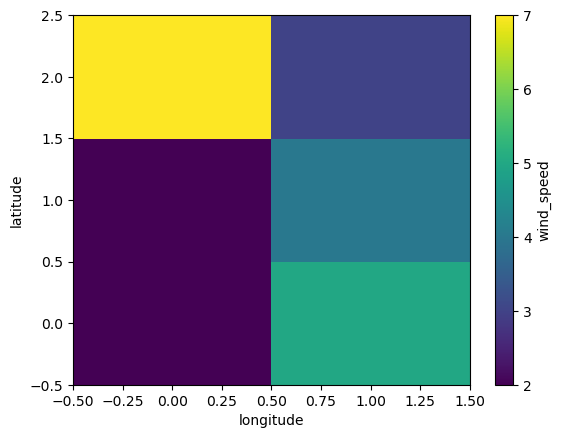

In [48]:
xrds['wind_speed'].plot.imshow(x='longitude', y='latitude')

### Example of 3D data

In [52]:
temperature = np.random.randint(20,30, size=(3,2,5))

xrds['temperature'] = (["latitude", "longitude", "depth"], temperature)
print(xrds)

<xarray.Dataset>
Dimensions:        (time: 24, depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * time           (time) int64 0 3600 7200 10800 ... 72000 75600 79200 82800
Dimensions without coordinates: depth, latitude, longitude
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 2 5 2 4 7 3
    temperature    (latitude, longitude, depth) int64 21 27 26 24 ... 24 25 23


### 3D data from pandas dataframe to 3D grid

So how exactly do you do this? I'll create a dummy dataframe first

In [56]:
# Create lists to store the coordinates and salinity values
depth_coordinates = []
latitude_coordinates = []
longitude_coordinates = []
salinity_values = []

# Generate the coordinates and salinity values for the grid
for d in depth:
    for lat in latitude:
        for lon in longitude:
            depth_coordinates.append(d)
            latitude_coordinates.append(lat)
            longitude_coordinates.append(lon)
            salinity = np.random.uniform(30, 35)  # Random salinity value between 30 and 35
            salinity_values.append(salinity)

# Create a DataFrame
data = {
    'Depth': depth_coordinates,
    'Latitude': latitude_coordinates,
    'Longitude': longitude_coordinates,
    'Salinity': salinity_values
}

df = pd.DataFrame(data)
print(df)

    Depth  Latitude  Longitude   Salinity
0       0   78.5425    30.0131  31.941480
1       0   78.5425    28.7269  33.687916
2       0   79.1423    30.0131  34.484465
3       0   79.1423    28.7269  31.757352
4       0   80.7139    30.0131  32.768646
5       0   80.7139    28.7269  33.228264
6      10   78.5425    30.0131  33.998241
7      10   78.5425    28.7269  30.456726
8      10   79.1423    30.0131  32.245193
9      10   79.1423    28.7269  30.261367
10     10   80.7139    30.0131  31.330515
11     10   80.7139    28.7269  32.748967
12     20   78.5425    30.0131  32.973284
13     20   78.5425    28.7269  32.183599
14     20   79.1423    30.0131  33.724410
15     20   79.1423    28.7269  31.688281
16     20   80.7139    30.0131  30.751796
17     20   80.7139    28.7269  33.266363
18     50   78.5425    30.0131  31.208348
19     50   78.5425    28.7269  32.547450
20     50   79.1423    30.0131  34.994847
21     50   79.1423    28.7269  33.263189
22     50   80.7139    30.0131  32

Now, let's create a multidimensional grid for our sea_surface_skin_temperature variable. We need to be a bit careful with the order here. The dataframe is sorted first by depth (5 depths), then by latitude (3 latitudes), then by longitude (2 longitudes). We should mirror that order.

In [58]:
salinity_3d_array = np.array(df['Salinity']).reshape(5,3,2)
print(salinity_3d_array)

[[[31.94148047 33.68791591]
  [34.48446533 31.75735182]
  [32.76864564 33.2282641 ]]

 [[33.99824065 30.45672553]
  [32.24519253 30.26136699]
  [31.33051476 32.74896701]]

 [[32.97328387 32.18359921]
  [33.72441001 31.68828097]
  [30.7517957  33.2663634 ]]

 [[31.20834819 32.54745042]
  [34.99484749 33.26318936]
  [32.49245183 30.04737201]]

 [[33.42610171 30.19178666]
  [30.31389526 33.8939196 ]
  [30.58649152 33.11315698]]]


In [63]:
xrds['salinity'] = (["depth", "latitude", "longitude"], salinity_3d_array) 
# Careful again with the order of your dimensions - it will fail if you get it wrong
print(xrds)

<xarray.Dataset>
Dimensions:        (time: 24, depth: 5, latitude: 3, longitude: 2)
Coordinates:
  * time           (time) int64 0 3600 7200 10800 ... 72000 75600 79200 82800
Dimensions without coordinates: depth, latitude, longitude
Data variables:
    chlorophyll_a  (depth) float64 21.5 18.5 17.6 16.8 15.2
    wind_speed     (latitude, longitude) int64 2 5 2 4 7 3
    temperature    (latitude, longitude, depth) int64 21 27 26 24 ... 24 25 23
    salinity       (depth, latitude, longitude) float64 31.94 33.69 ... 33.11


# Variable attributes

Hurrah! Your data are in the xarray dataset object. But are you ready to export a NetCDF file? Will that file be compliant with the FAIR principles? No! We need metadata.

Variable attributes are metadata that describe the variables.

# Global attributes

# Exporting your xarray object to a NetCDF file

# Checking your data